# PROJEKT PRI FINANČNEM PRAKTIKUMU
Najprej izberemo število točk $n = 3k$ za $k$ iz naravnih števil. Nato naključno generiramo te točke in jih zapišemo v slovar $p$.
Ključi slovarja so števila od 0 do $n-1$, vrednosti pa $x$ in $y$ koordinate točk.


In [1]:
# za merjenje časa, ki ga porabi program potrebujemo uvoziti:
import time

#izberemo število točk
n = 15

if n <= 0:
    print("Napaka: število točk mora biti pozitivno")
elif n % 3 != 0:
    print("Napaka: izbrati je treba 3k število točk za k iz naravnih števil")
else:
    print("Uspešno izbrano število točk")

    
# Naključno generiramo n točk v kvadratu (0,1)x(0,1) in jih shranimo v slovar
p = {i: (random(), random()) for i in range(n)}

# Nato definiramo matriko M v katero bomo zapisali vse razdalje med točkami.
M = matrix(RR,n)

# Sledeča zanka v matriko M zapiše razdalje 
for i in range(n):
    for j in range(n):
        M[i,j] = (((p[i][0])-(p[j][0]))^2 + ((p[i][1])-(p[j][1]))^2)^((0.5))

        
# Naprej nas zanima ali se dve povezavi med seboj sekata. V ta namen definiramo funkcijo 'seka', ki nam 
# pove ali daljica ij seka daljico lk, kjer so i,j,k,l števila med 0 in n-1.       
def zasuk(a,b,c):
    A = matrix(RR,3)
    A[0] = (1, p[a][0],p[a][1])
    A[1] = (1, p[b][0],p[b][1])
    A[2] = (1, p[c][0],p[c][1])
    return(det(A))

def seka(a,b,c,d):
    if zasuk(a,b,c)*zasuk(a,b,d)<0 and zasuk(a,c,d)*zasuk(b,c,d)<0:
        return(1)
    else:
        return(0)

Uspešno izbrano število točk


## Maksimizacija vsote robov
Definiramo celoštevilski linearni program, ki maksimira vsoto dolžin vseh povezav, ki jih bomo uporabili.

In [2]:
start = time.time()

clp = MixedIntegerLinearProgram(maximization=True)

# Definiramo spremenljivko x, ki zavzame vrednost 0 ali 1
x = clp.new_variable(binary=True)

# Dodamo pogoje, ki jih je potrebno upoštevati v našem programu:

#  1) Iz vsake točke lahko gresta natanko 2 povezavi, ali pa vanjo pride natanko 1 povezava.
for i in range(n):
    clp.add_constraint(sum(x[i, j] + 2*x[j, i] for j in range(n)) == 2)
    
#  2) Če se dve povezavi sekata, je lahko uporabljena zgolj ena izmed niju.
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                clp.add_constraint(x[i,j]+x[j,i]+x[k,l]+x[l,k]+seka(i,j,k,l)<=2)
                
                
# Dodamo cilj našega programa. V našem primeru maksimum vsote uporabljenih povezav.
clp.set_objective(sum(x[i, j]*M[i,j] for i in range(n) for j in range(n)))

# Izračunamo vrednost vsote.
vsota = clp.solve()
print(f'Vsota povezav je {vsota}')

end = time.time()
cas = end - start
print(f"Program porabi {cas}")


Vsota povezav je 5.4354234858315245
Program porabi 172.84718656539917


In [3]:
# Pogledamo katere povezave smo uporabili.
povezave = clp.get_values(x)
povezave1 = {k:v for k, v in povezave.items() if v == 1}
povezave1.keys()

dict_keys([(13, 0), (13, 1), (9, 2), (3, 5), (3, 11), (6, 4), (6, 14), (7, 8), (7, 12), (9, 10)])

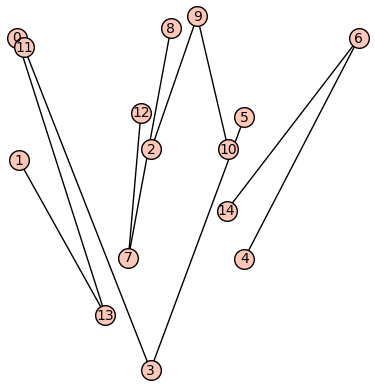

In [4]:
# Narišemo graf, ki prikazuje izbrane točke in povezave.
G = Graph([e for e, v in clp.get_values(x).items() if v == 1])
G._pos = p
G.plot()

# Maksimizacija najkrajšega roba
V tem primeru bomo povezave izbrali tako, da bomo maksimirali dolžino najkrajše izbrane povezave.

In [5]:
start2 = time.time()

clp2 = MixedIntegerLinearProgram(maximization=True)

# Definiramo spremenljivko y, ki zavzame vrednost 0 ali 1
y = clp2.new_variable(binary=True)

# Definiramo realno nenegativno spremenljivko w
w = clp2.new_variable(real=True, nonnegative=True)

# Definiramo spremenljivko Mmax, ki je najdaljša možna povezave med izbranimi točkami
Mmax = max(M[i,j] for i in range(n) for j in range(n))

# Dodamo pogoje, ki jih je potrebno upoštevati v našem programu:

#  1) Iz vsake točke lahko gresta natanko 2 povezavi, ali pa vanjo pride natanko 1 povezava.
for i in range(n):
    clp2.add_constraint(sum(y[i, j] + 2*y[j, i] for j in range(n)) == 2)
    
#  2) Če se dve povezavi sekata, je lahko uporabljena zgolj ena izmed niju.
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                clp2.add_constraint(y[i,j]+y[j,i]+y[k,l]+y[l,k]+seka(i,j,k,l)<=2)
                
#  3) Spremenljivka w bo vedno manjša ali enaka najkrajši povezavi, ki jo bomo uporabili (za katero je y[i,j] == 1).
for i in range(n):
    for j in range(n):
        clp2.add_constraint(w[1] <= M[i, j] + (1 - y[i, j]) * Mmax)
        
# Kot cilj maksimiramo velikost w, kar maksimira dolžino najkrajše uporabljene povezave.
clp2.set_objective(w[1])

# Dobimo dolžino najkrajše uporabljene povezave.
dolzina2 = clp2.solve()
print(f'Dolžina najkrajše uporabljene povezave je {dolzina2}')

end2 = time.time()
cas2 = end2-start2
print(f"Program porabi {cas2}")

Dolžina najkrajše uporabljene povezave je 0.4334886153207035
Program porabi 152.79103255271912


In [6]:
# Pogledamo katere povezave smo uporabili.
povezave2 = clp2.get_values(y)
povezave3 = {k:v for k, v in povezave2.items() if v == 1}
povezave3.keys()

dict_keys([(9, 0), (13, 1), (6, 2), (3, 10), (3, 14), (6, 4), (7, 5), (7, 8), (9, 11), (13, 12)])

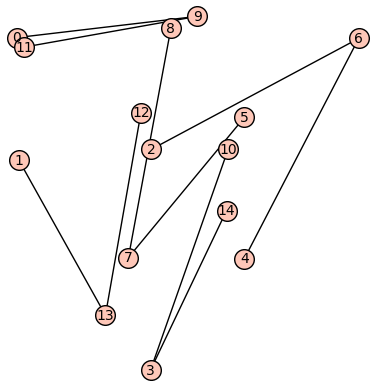

In [7]:
# Narišemo graf, ki prikazuje izbrane točke in povezave.
G2 = Graph([e for e, v in clp2.get_values(y).items() if v == 1])
G2._pos = p
G2.plot()

## Primerjava vsot in časov postopkov

In [8]:
# Za primer maksimiranja najkrajše povezave izračunamo še vsoto vseh uporabljenih povezav in jo primerjamo s prejšnjo
def getList(povezave3):
    list1 = []
    for key in povezave3.keys():
        list1.append(key)
    return list1

list2 = getList(povezave3)

vsota2 = sum(M[list2[i][0],list2[i][1]] for i in range(n*(2/3)))

razmerje_vsot = vsota/vsota2


# Za primer maksimiranja vsote povezav poiščemo še najkrajšo uporabljeno povezavo
list1 = getList(povezave1)

dolzina = min(M[list1[i][0],list1[i][1]] for i in range(n*(2/3)))



print(f'Vsota iz maksimiranja vsote {vsota}')
print(f'Vsota iz maksimiranja najkrajše povezave {vsota2}' )      
print(f'Razmerje vsot {razmerje_vsot}')
print(f'Najkrajša povezava iz maksimiranja vsote {dolzina}')
print(f'Najkrajša povezava iz maksimiranja najkrajše povezave {dolzina2}' )      
print(f'Razmerje najkrajših povezav {dolzina/dolzina2}')
print(f"Program maksimiranja vsot porabi {cas} sekund")
print(f"Program maksimiranja najkrajše povezave porabi {cas2} sekund")
print(f'Razmerje časov {cas/cas2}')

Vsota iz maksimiranja vsote 5.4354234858315245
Vsota iz maksimiranja najkrajše povezave 5.05117029142583
Razmerje vsot 1.07607211244847
Najkrajša povezava iz maksimiranja vsote 0.335559611690526
Najkrajša povezava iz maksimiranja najkrajše povezave 0.4334886153207035
Razmerje najkrajših povezav 0.774090944562114
Program maksimiranja vsot porabi 172.84718656539917 sekund
Program maksimiranja najkrajše povezave porabi 152.79103255271912 sekund
Razmerje časov 1.1312652560663852


## Analiza podatkov
Od tu naprej bomo shranili in analizirali podatke, ki jih bomo pridobili z zgornjim programom

In [9]:
# V spodnjih matrikah so shranjeni rezultati poskusov
# V vsaki matriki je 5 stolpcev, ki po vrsti zadoščajo poskusu za n = 3, 6, 9, 12, 15. Za večje n, program porabi preveč časa.
# V vsaki matriki je 10 vrstic. Torej za vsak n kot zgoraj smo program pognali 10-krat in shranili rezultate, nato pa bomo izračunali njihovo povprečje.

#vsota dolžin pri maksimiranju vsot
Vsota_max_vsota = load('a')

#vsota dolžin pri maksimiranju najkrajše povezave
Vsota_max_razdalja = load('b')

#razmerje med zgornjima dvema vsotama
Vsota_razmerje = load('c')

#dolžina najkrajše uporabljene povezave pri maksimiranju vsot
Dolzina_max_vsota = load('d')

#dolžina najkrajše uporabljene povezave pri maksimiranju najkrajše povezave
Dolzina_max_razdalaj = load('e')

#razmerje med zgornjima družinama
Dolzina_razmerja = load('f')

#čas porabljen pri maksimiranju vsot
Cas_max_vsota = load('g')

#čas porabljen pri maksimiranju najkrajše povezave
Cas_max_razdalja = load('h')

#razmerje med zgornjima časoma
Cas_razmerje = load('i')

In [10]:
#ta del smo uporabili pri shranjevanju podatkov v zgornje matrike (spreminjali smo samo i(0:9),j(0:4) in n(3, 6, 9, 12, 15))
i = 10
j = 10
Vsota_max_vsota[i,j] = vsota
Vsota_max_razdalja[i,j] = vsota2
Vsota_razmerje[i,j] = vsota/vsota2
Dolzina_max_vsota[i,j] = dolzina
Dolzina_max_razdalaj[i,j] = dolzina2
Dolzina_razmerja[i,j] = dolzina/dolzina2
Cas_max_vsota[i,j] = cas
Cas_max_razdalja[i,j] = cas2
Cas_razmerje[i,j] = cas/cas2

        
Vsota_max_vsota.save('a')
Vsota_max_razdalja.save('b')
Vsota_razmerje.save('c')
Dolzina_max_vsota.save('d')
Dolzina_max_razdalaj.save('e')
Dolzina_razmerja.save('f')
Cas_max_vsota.save('g')
Cas_max_razdalja.save('h')
Cas_razmerje.save('i')

[0.909549531928634  2.11243116615561  3.60582028828559  4.19282721310488  5.96780620444913]
[ 1.55026442687423  2.68801137971026  3.36696358929073  5.62999890839395  7.83268681601137]
[ 1.87865238317819  2.15042817525427  3.29413637896628  4.27292702224397  6.10574293730737]
[ 2.15275840851067  2.81485096749030  3.69453721120628  6.36621612082201  6.46908252506276]
[ 1.64098085710059  2.28058766853816  4.43115415418573  5.71904727095663  6.24423607739555]
[ 1.62194806687457  3.45948400074018  4.13953046991473  4.80973345487401  6.02482082267185]
[ 1.52197098210356  2.91523784278290  3.14221321066479  5.46879047351082  4.97643747374305]
[ 1.06514082365908  2.62420833322166  3.82983328200209  3.78759821116640  5.64109843399025]
[ 1.44936141380182  2.23227859423433  4.18010940673100  5.98900310465457  6.89007032269772]
[0.745551360844521  2.34064148398497  3.47100759586549  5.11231655451967  5.05117029142583]

### Podatki iz JSON

In [ ]:
import json

def rekonstruiraj_podatke(T, *d):
    p, M = T
    p = {Integer(k): v for k, v in p.items()}
    M = Matrix(M)
    d = [(v, c, E, Graph(G)) for v, c, E, G in d]
    for v, c, E, G in d:
        G._pos = p
    return ((p, M), *d)

In [ ]:
with open("poganjanje18-30.json") as f:
    data = {Integer(n): rekonstruiraj_podatke(*d) for n, d in json.load(f).items()}

In [ ]:
v, c, E, G = data[18][1] # podatki za n = 18, max vsota
print(v, c, E)
G.plot()

In [ ]:
v, c, E, G = data[18][2] # podatki za n = 18, max min povezava
print(v, c, E)
G.plot()